In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Define Functions

In [2]:
######## Define Composite Properties ########
from math import *
import numpy as np
from numpy.linalg import inv

## Define Functions
def eta(P1, P2, xi):
    '''Function used in the Halpin-Tsai relationships.'''
    return ((P1/P2)-1)/((P1/P2)+xi)
#

def transIsoStiffness(E1, nu1, E2, nu2, V, HT=True):
    '''Return the 2D stiffness tensor of a transversely isotropic composite made
       from materials 1 and 2. Inputs required are the stiffness and Poisson's ratio of
       both materials (E1, nu1, E2, nu2) and volume fraction V of material 1.
       Properties are calculated using Halpin-Tsai relationships by default (HT = True),
       but a Reuss model can be used if desired.'''

    # Calculate Base Material Properties
    G1 = E1/(2*(1+nu1))
    G2 = E2/(2*(1+nu2))

    # Calculate Material Properties
    Ex = E1*V + E2*(1-V) #Voigt

    if HT: #Halpin-Tsai
        Ey = E2*(1 + 2*eta(E1,E2,2)*V)/(1 - eta(E1,E2,2)*V)
        Gxy = G2*(1 + 1*eta(G1,G2,1)*V)/(1 - eta(G1,G2,1)*V)
    else: #Reuss
        Ey = 1/(V/E1+(1-V)/E2)
        Gxy = 1/(V/G1+(1-V)/G2)

    nuxy = nu1*V+nu2*(1-V) #Voigt
    nuyx = nuxy*Ey/Ex #Reciprocal

    # Create Stiffness Matrix
    C = [[Ex/(1-nuxy*nuyx),      nuyx*Ex/(1-nuxy*nuyx), 0],
         [nuyx*Ex/(1-nuxy*nuyx), Ey/(1-nuxy*nuyx),      0],
         [0,                     0,                     Gxy]]

    return np.array(C)
#

def transIsoCompliance(E1, nu1, E2, nu2, V, HT=True):
    return inv(transIsoStiffness(E1, nu1, E2, nu2, V, HT=True))
#

def rotaT(theta):
    '''Matrix for stress rotation in 2D.'''
    c = cos(theta)
    s = sin(theta)
    return np.array([[c**2, s**2, 2*s*c],[s**2, c**2, -2*s*c],[-s*c, s*c, c**2-s**2]])
#

def rotaTP(theta):
    '''Matrix for strain rotation in 2D.'''
    c = cos(theta)
    s = sin(theta)
    return np.array([[c**2, s**2, s*c],[s**2, c**2, -s*c],[-2*s*c, 2*s*c, c**2-s**2]])
#

def rotateStress(stress, theta):
    '''Rotate 2D stress counterclockwise. Input stress as a 3x1 vector'''
    T = rotaT(theta)
    return T.dot(stress)
#

def rotateStrain(strain, theta):
    '''Rotate 2D strain counterclockwise. Input  strain as a 3x1 vector'''
    TP = rotaTP(theta)
    return TP.dot(strain)

def rotateStiffness(C, theta):
    '''Rotate the 2D stiffness tensor C counterclockwise by angle theta.'''
    # Define rotation matrix T and T'
    T = rotaT(theta)
    TP = rotaTP(theta)

    # Stress tensor rotations
    return inv(T).dot(C).dot(TP)

def rotateCompliance(S, theta):
    '''Rotate the 2D compliance tensor S counterclockwise by angle theta.'''
    # Define rotation matrix T and T'
    T = rotaT(theta)
    TP = rotaTP(theta)

    # Stress tensor rotations
    return inv(TP).dot(S).dot(T)

def laminateStiffness(C, thetas, ts):
    '''Return the stiffness of a laminate given a single input C aligned with the
    fiber orientation of the base material, an array of angles corresponding to the
    laminate stack and an array of thicknesses ts corresponding to each lamina.'''
    return sum([rotateStiffness(C,theta)*t for theta,t in zip(thetas,ts)])/sum(ts)

def laminateCompliance(CLam):
    return inv(CLam)

def ShearModulus(Gm, Gf, V):
    '''Returns the Shear modulus of a lamina by Halpin-Tsai formulation'''
    n = (Gf/Gm -1)/ (Gf/Gm + 1)
    G12 = Gm*(1 + n*V)/(1 - n*V)
    return (G12)

def Compressivestrength(G12, tau12, phi):
    '''Returns the compressive strength of a laminate when plastic microbuckling is the
    dominant failure mechanism. Takes an input shear modulus, shear strength and the
    imperfection angle '''
    sig_com = 1/((1/G12) + (phi/tau12))
    return (sig_com)

def Weibullfailurestrength(Pf,L,L0,sig0):
    '''Calculates the failure strength for a given probablity of failure using Weibull Theory.
    Takes an input probability of failure, Length of the fiber, Reference length of the fiber and the reference
    strength.'''
    Failure_strength = sig0*np.exp((np.log(np.log(1/(1-Pf))) -np.log(L/L0))/m)
    return (Failure_strength)

def maxStressFail(stress, s1, s2, s12):
    '''Determine whether a composite will fail under a max stress condition.
    Takes an input stress in 2D (aligned with the fiber direction) and strengths
    in the 1, 2, and 12 direction. Will return true or false.'''
    return stress[0]>s1 or stress[1]>s2 or abs(stress[2])>s12


def tsaiHillFail(stress, s1, s2, s12):
    '''Determine whether a composite will fail under a Tsai-Hill condition.
    Takes an input stress in 2D (aligned with the fiber direction) and strengths
    in the 1, 2, and 12 direction. Will return true or false.'''
    return (stress[0]/s1)**2+(stress[1]/s2)**2-stress[0]*stress[1]/s1**2+(stress[2]/s12)**2 > 1

def laminaFail(stress, th, s1, s2, s12, criterion='Tsai-Hill'):
    '''Determine whether an arbitrary load will cause failure. Takes an input stress
    in 2D, an angle th, strengths in the 1, 2 and 12 direction, and the criterion to
    be used. Returns true or false.'''
    # Rotate stress
    s = rotateStress(stress,th)
    # Determine failure
    if criterion == 'Tsai-Hill':
        return tsaiHillFail(s, s1, s2, s12)
    elif criterion == 'Max Stress':
        return maxStressFail(s, s1, s2, s12)
    else:
        return False

### Solutions

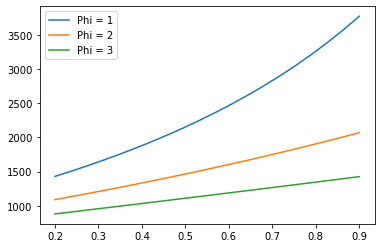

In [13]:
###Q3
Gm_3 = 1400       #MPa
Gf_3 = 110000    #MPa
tau12_3 = 80        #MPa
phi = [np.pi/180, np.pi*2/180, np.pi*3/180]
V = np.linspace(0.2, 0.9, 20)

Answer_3 = []
for i in phi:
    for j in V:
        G12_3 = ShearModulus(Gm_3, Gf_3, j)
        Strength_3 = Compressivestrength(G12_3, tau12_3, i)
        Answer_3.append(Strength_3)

phi1 = Answer_3[0:20:1]
phi2 = Answer_3[20:40:1]
phi3 = Answer_3[40:60:1]

# fig = plt.figure()
# plt.plot(V, phi1, label = ('Phi = 1'))       
# plt.plot(V, phi2, label = ('Phi = 2'))
# plt.plot(V, phi3, label = ('Phi = 3'))
# plt.xlabel=("Volume Fraction")
# plt.ylabel= ("Compressive Failure Strength (MPa)")
# plt.legend()
# plt.show()

In [30]:
####Q4
Pf = [0.01, 0.5]
L = 0.3        #m
L0 = 0.1      #m
sig0 = 963   #MPa
m = 14.2
Answer1_4 = Weibullfailurestrength(Pf[0],L,L0,sig0)
Answer2_4 = Weibullfailurestrength(Pf[1],L,L0,sig0)
# print ("Applied stress for 1% chance of failure is:", Answer1_4, " MPa")
# print ("Applied stress for 50% chance of failure is:", Answer2_4, " MPa")

Applied stress for 1% chance of failure is: 644.6658872464268  MPa
Applied stress for 50% chance of failure is: 868.5937982703393  MPa


In [20]:
###Q6
sig1_6 = 500 #600
sig2_6 = 20 #30
sig12_6 = 50 #70
sig_app_1_6 = np.array([100,15,0])
sig1 = rotateStress(sig_app_1_6, -np.pi*15/180)
Answer1_6 = maxStressFail(sig1, sig1_6, sig2_6, sig12_6)
Answer2_6 = tsaiHillFail(sig1, sig1_6, sig2_6, sig12_6)
# print ("Maximum stress criterion:", Answer1_6)
# print ("Tsai Hill criterion:", Answer2_6)

Maximum stress criterion: True
Tsai Hill criterion: True


In [ ]:
####Q7
sig1_7 = 2100
sig2_7 = 100
sig12_7 = 180
sig_app_1_7 = np.array([2000,110,100])
sig_app_2_7 = np.array([2200, 90, 80])
sig_app_3_7 = np.array([1800, 60, 200])
Cases = [sig_app_1_7, sig_app_2_7, sig_app_3_7]

Failure_prediction_MaxStress_7 =[]
Failure_prediction_TsaiHill_7 =[]

for i in range(0,3):
    A = Cases[i]
    Answer1 = maxStressFail(A, sig1_7, sig2_7, sig12_7)
    Answer2 = tsaiHillFail (A, sig1_7, sig2_7, sig12_7)
    Failure_prediction_MaxStress_7.append(Answer1)
    Failure_prediction_TsaiHill_7.append(Answer2)

In [35]:
####Q8
Strengths = [900, 150, 200]  #MPa
sig_app_8 = [300, 80, 100]   #MPa
theta_8 = np.arange(0,np.pi, np.pi/360)

Failure_prediction_MaxStress_8 =[]
Failure_prediction_TsaiHill_8 =[]


for i in theta_8:
    Case1 = laminaFail(sig_app_8, i, Strengths[0] , Strengths[1] , Strengths[2] , criterion='Max Stress')
    Case2 = laminaFail(sig_app_8, i, Strengths[0] , Strengths[1] , Strengths[2] , criterion='Tsai-Hill')
    if Case1 == True:
        Failure_prediction_MaxStress_8.append(i*180/np.pi)
    if Case2 == True:
        Failure_prediction_TsaiHill_8.append(i*180/np.pi)
        
# print ("Angle for Maximum stress:", Failure_prediction_MaxStress_8[0])
# print ("Angle for TsaiHill:", Failure_prediction_TsaiHill_8[0])

Angle for Maximum stress: 58.5
Angle for TsaiHill: 50.5
